# Credit Card Fraud Detection

***

## Contents
1. [Overview](#1)
2. [Data](#2)
3. [Class imbalance](#3)<br>
    3.1 [Undersampling](#3.1)<br>
    3.2 [Oversampling](#3.2)<br>
    3.3 [Over and Undersampling](#3.3)<br>
4. [Binary Classification](#4)<br>
    4.1 [Baseline](#4.1)<br>
    4.2 [Undersampling](#4.2)<br>
    4.3 [Oversampling](#4.3)<br>
    4.4 [Over and Undersampling](#4.4)<br>
    4.5 [Outliers](#4.5)<br>
5. [Conclusion](#5)

***

<a id = '1'></a>
## 1. Overview
In this notebook we will explore modelling a classification model to detect credit card fraud. Fraud detection (anomaly detection) is a common problem tackled with machine learning and typically contains extremely imbalanced classes which leads to additional considerations from the usual classification problems.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, cross_val_score, cross_validate
from collections import Counter
from sklearn.compose import ColumnTransformer

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

***
<a id = '2'></a>
## 2. Data
The dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).
<blockquote>The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. </blockquote>

In [2]:
# Import data
df = pd.read_csv('creditcard.csv')

print(df.head())
print(df.columns)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

As mentioned in the description of the dataset, the dataset contains 'Time', 'Amount', and 'Class' columns, along with 28 other 'V' features which are the result of PCA transformation for confidentiality reasons. Hence we will be working with the dataset without knowing what the majority of the columns describe.

In [3]:
# Check nulls
df.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

0    284315
1       492
Name: Class, dtype: int64


Text(0.5, 1.0, 'Distribution of Classes')

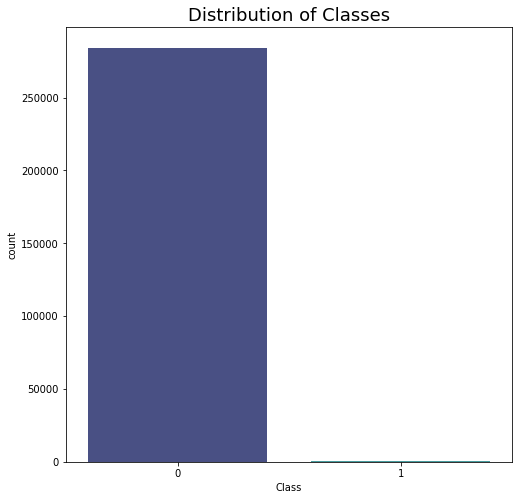

In [4]:
# Check class imbalance
print(df.Class.value_counts())

fig, ax = plt.subplots(figsize = (8,8))
sns.countplot(ax = ax, x = "Class", data = df, palette = 'mako')
ax.set_title('Distribution of Classes', fontsize = 18)

As mentioned in the description, we have verified that the dataset contains 492 fraudulent transactions out of 284807 transactions. Additionally, no NaN values were found so we do not have to worry about resolving missing data.

<AxesSubplot:ylabel='Density'>

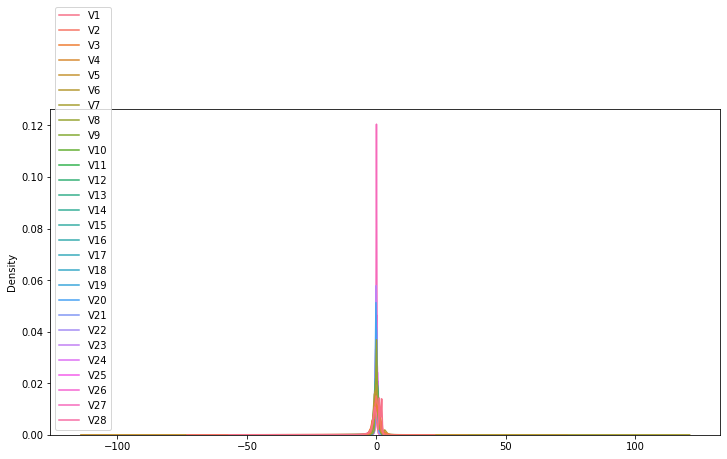

In [5]:
# Distribution of V columns
fig, ax = plt.subplots(figsize = (12,6))
sns.kdeplot(data = df.drop(['Amount', 'Time','Class'], axis = 1), ax = ax)


Preliminary investigations suggest that all the 'V' features are centred around 0.

Text(0.5, 1.0, 'Transaction Amounts')

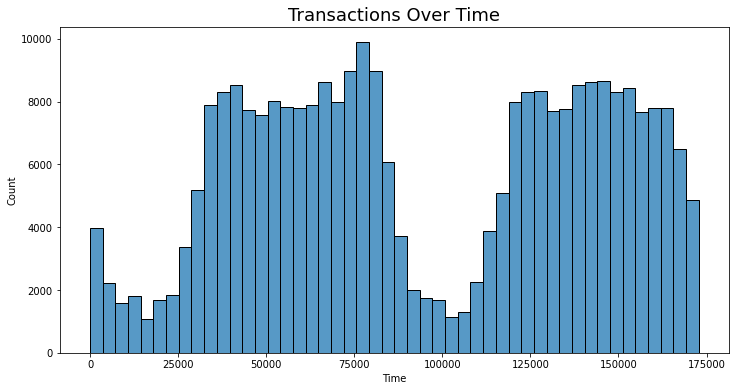

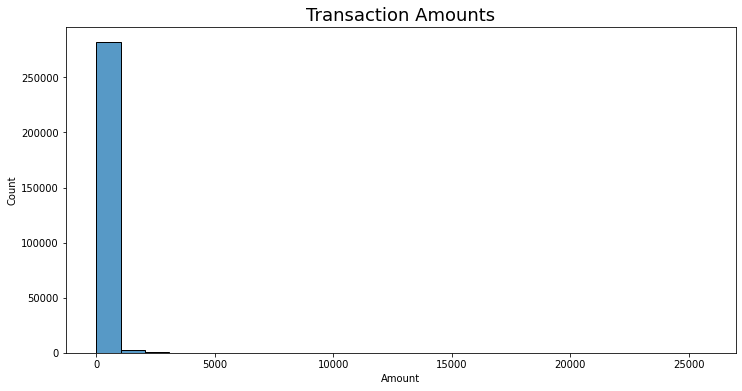

In [6]:
# Distribution of Time and Amount
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df, x = 'Time', ax = ax, bins = 48, palette = 'mako')
ax.set_title('Transactions Over Time', fontsize = 18)

fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df, x = 'Amount', ax = ax, bins = 25, palette = 'mako')
ax.set_title('Transaction Amounts', fontsize = 18)

Looking at the transactions made over time, we observe that the dataset contains transactions over a 48 hours (172799 seconds) time period with a clear relationship with number of transactions vs time most likely following office working hours, while the vast majority of transaction amounts are below $1000.

Text(0.5, 1.0, 'Number of Non-Fraudulent Transactions Over Time')

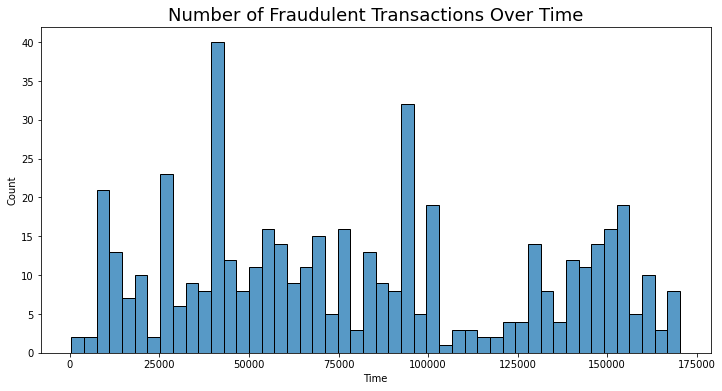

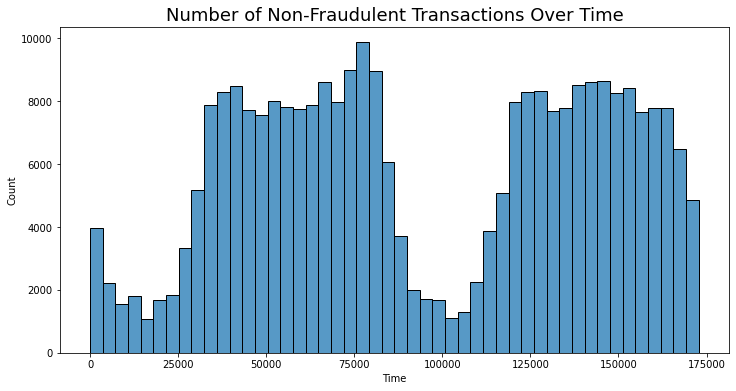

In [7]:
# Compare fraud and no fraud over time
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df.loc[df.Class == 1], x = 'Time', ax = ax, bins = 48, palette = 'mako')
ax.set_title('Number of Fraudulent Transactions Over Time', fontsize = 18)

fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df.loc[df.Class == 0], x = 'Time', ax = ax, bins = 48, palette = 'mako')
ax.set_title('Number of Non-Fraudulent Transactions Over Time', fontsize = 18)

When breaking down the visualisation to show the difference between fraudulent and non-fraudulent transactions over time, non-fraudulent transactions appears to follow the same pattern observed before, while fradulent transactions do not appear to follow any fixed patterns. As the dataset only spans a period of 48 hours, we cannot conclude that frauds do not follow a certain pattern with regards to time as there may be a seasonal aspect to fraud that lies undetected in this dataset.

Text(0.5, 1.0, 'Amount of Money Involved in Non-Fraudulent Transactions Over Time')

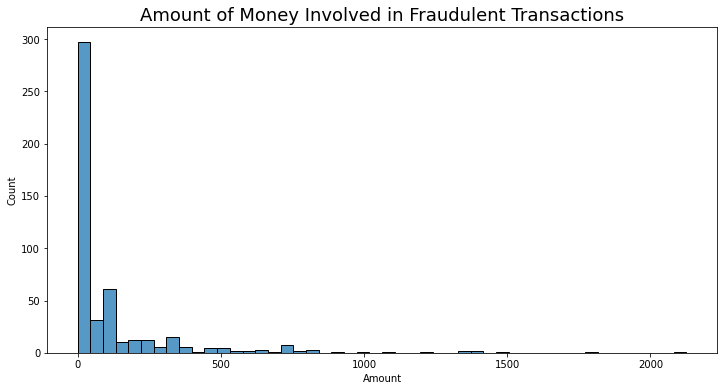

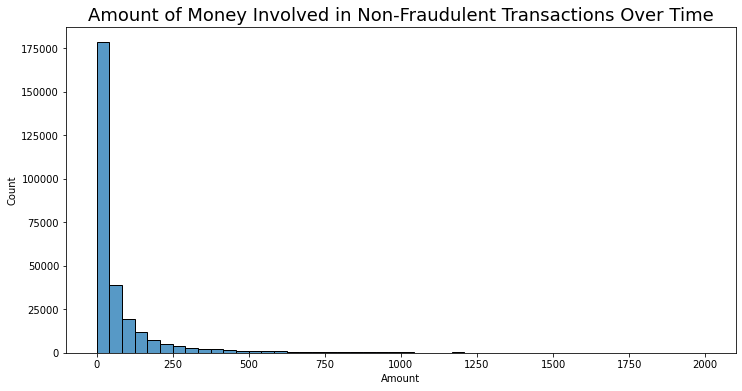

In [8]:
# Compare fraud and no fraud transaction amounts
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df.loc[df.Class == 1], x = 'Amount', ax = ax, bins = 48, palette = 'mako')
ax.set_title('Amount of Money Involved in Fraudulent Transactions', fontsize = 18)

fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(data = df.loc[(df.Class == 0)&(df.Amount <= 2000)], x = 'Amount', ax = ax, bins = 48, palette = 'mako')
ax.set_title('Amount of Money Involved in Non-Fraudulent Transactions Over Time', fontsize = 18)

Previously we have established that the vast majority of transaction amounts are below \\$1000. Looking at transaction amounts between fraudulent and non-fraudulent transactions we see that most of the transactions actually occur within the <$50 range. Additionally, number of non-fraudulent transactions appear to decrease as transaction amount increases, resulting in a smooth curve while a similar smoothly decreasing pattern is not observed in fraudulent transactions. This may be due to the low number of sampled we have for fraudulent transactions, increasing the number of samples may or may not lead to a similar curve to non-fraudulent transactions.

Text(0.5, 1.0, 'Non-Fraudulent Transactions')

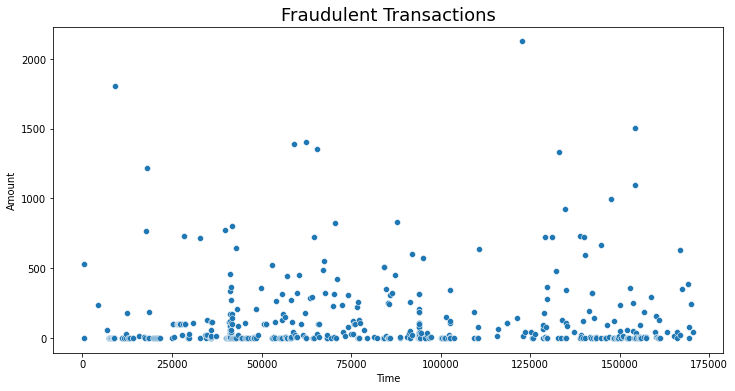

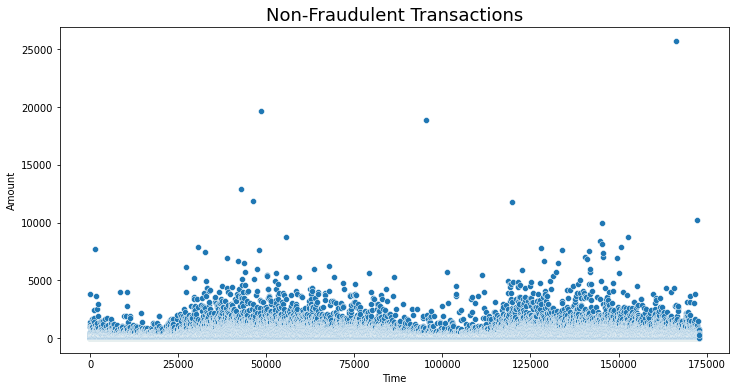

In [9]:
# Visualise fraud and no fraud transactions based on time and amount
fig, ax = plt.subplots(figsize = (12,6))
sns.scatterplot(x = 'Time', y = 'Amount', palette = 'mako', data = df.loc[df.Class == 1])
ax.set_title('Fraudulent Transactions', fontsize = 18)

fig, ax = plt.subplots(figsize = (12,6))
sns.scatterplot(x = 'Time', y = 'Amount', palette = 'mako', data = df.loc[df.Class == 0])
ax.set_title('Non-Fraudulent Transactions', fontsize = 18)

Looking at scatterplots of amount vs time for both classes we observe that non-fraudulent transactions containing a larger amount of money are typically made during what was presumed to be the typical office working hours while no discernable pattern for fraudulent transactions can be made here.

<AxesSubplot:>

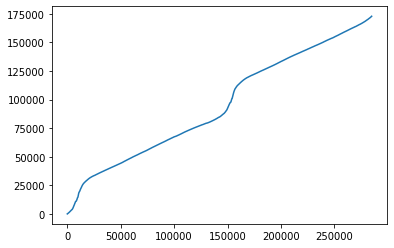

In [10]:
# Time
df.Time.plot()

With regards to the 'Time' feature, feeding the columns as it is into the machine learning algorithm would not work as the algorithm will not be able to detect that it is a time based feature. The above plot is a 'Time' vs 'Index' plot of the dataset showing that at certain point in the dataset a larger period of time is passed (likely due to fewer transactions made), notably at the start and middle of the dataset. The data also does not capture the cyclical nature of 24 hour days, leading to samples being weighted differently based on the magnitude of their 'Time' feature.

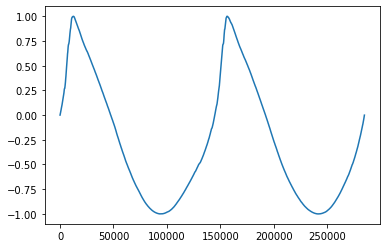

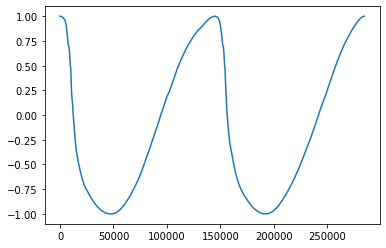

In [11]:
# Add columns for sine and cosine of Time
df['time_sine'] = np.sin(2*np.pi*df.Time / (24*60*60))
df['time_cosine'] = np.cos(2*np.pi*df.Time / (24*60*60))

# Visualisation
df.time_sine.plot()
plt.show()
df.time_cosine.plot()
plt.show()

To combat the issues stated before, we can simply encode the data in a cyclical manner by taking its sine. However, this will lead to another problem whereby certain times of day cannot be differentiated from each other. What this means is that in a 48 hours dataset, each point in time within a 24 hours timeframe should only be repeated once. However when looking at the plot for the sine of 'Time' feature we observe that any horizontal line drawn within the limits will cut through 4 points on the curve, meaning that some point in time within a 24 hours timeframe are repeated thrice.

To resolve this issue an out of phase encoding will be added, which is simply taking the cosine of the 'Time' feature.

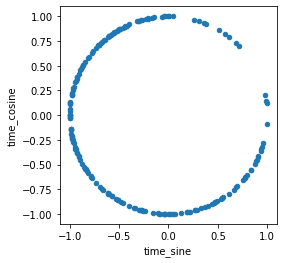

In [12]:
# Visualise sine/cosine
df.sample(200).plot.scatter('time_sine','time_cosine').set_aspect('equal')
plt.show()

By taking both the sine and cosine of the 'Time' feature, we will end up encoding the feature similarly to how time would appear on our clocks if the clock face is 24 hours instead of the typical 12 hours clock face, allowing the machine learning algorithm to differentiate time properly.

In [13]:
# Amount
rob_scaler = RobustScaler()
df['amount_scaled'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1)) # amount will be rescaled again when splitting into train/test

As the 'V' columns are a result of PCA, they are assume to already be scaled, hence we will only apply robust scaler to the 'Amount' column to scale the data for analysis/modelling. Robust scaler is chosen to combat outliers present in the dataset.

***

<a id = '3'></a>
## 3. Class Imbalance
In this section we will explore different sampling methods to resolve the class imbalance issues and how they may affect the dataset.

In [14]:
# Original
X = df.drop(['Class','Time','Amount'], axis = 1)
y = df['Class']

counter = Counter(y)
print(counter)

X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 33).fit_transform(X.values)
X_pca = PCA(n_components = 2, random_state = 33).fit_transform(X.values)

Counter({0: 284315, 1: 492})


Text(0.5, 1.0, 'PCA')

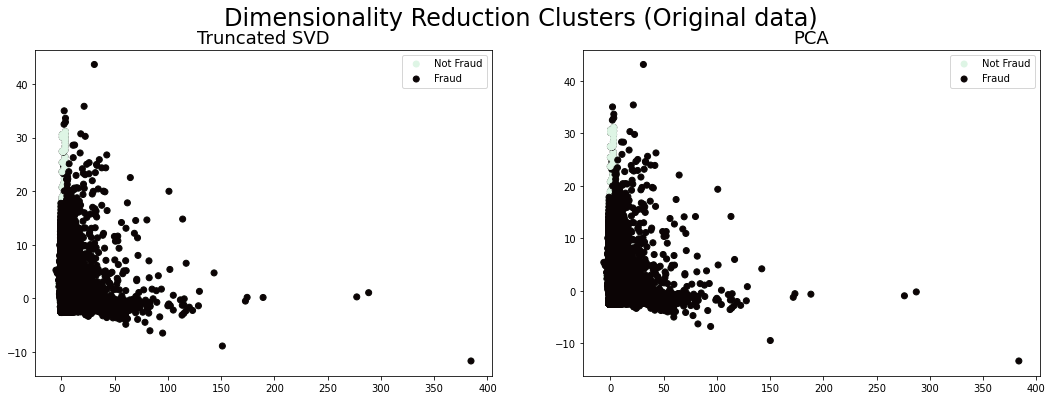

In [15]:
# Dimensionality reductions (Original samples)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
fig.suptitle('Dimensionality Reduction Clusters (Original data)', fontsize = 24)
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax1.legend()
ax1.set_title('Truncated SVD', fontsize = 18)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax2.legend()
ax2.set_title('PCA', fontsize = 18)

When applying dimensionality reduction methods to the original dataset, we observe that the clusters are not clearly separated.

<a id = '3.1'></a>
### 3.1 Undersampling
The first method we will be looking at will be undersampling, using the imblearn library's RandomUnderSampler.

0    492
1    492
Name: Class, dtype: int64


Text(0.5, 1.0, 'Distribution of Classes after Undersampling')

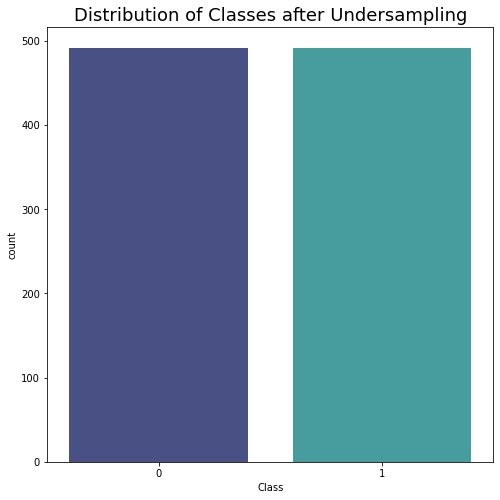

In [16]:
# Random under sampling to 50/50 Class ratio using imblearn
X_under = df.drop(['Class','Time','Amount'], axis = 1)
y_under = df['Class']

undersample = RandomUnderSampler(sampling_strategy = 1)
X_under, y_under = undersample.fit_resample(X_under, y_under)

subsampled_example = pd.concat([X_under,y_under], axis = 1)
print(subsampled_example.Class.value_counts())

fig, ax = plt.subplots(figsize = (8,8))
sns.countplot(ax = ax, x = "Class", data = subsampled_example, palette = 'mako')
ax.set_title('Distribution of Classes after Undersampling', fontsize = 18)

From the above we see that we have undersampled the non-fraudulent cases to match the number of fraudulent cases we have in the dataset.

Text(0.5, 1.0, 'Correlation Matrix of Subsample')

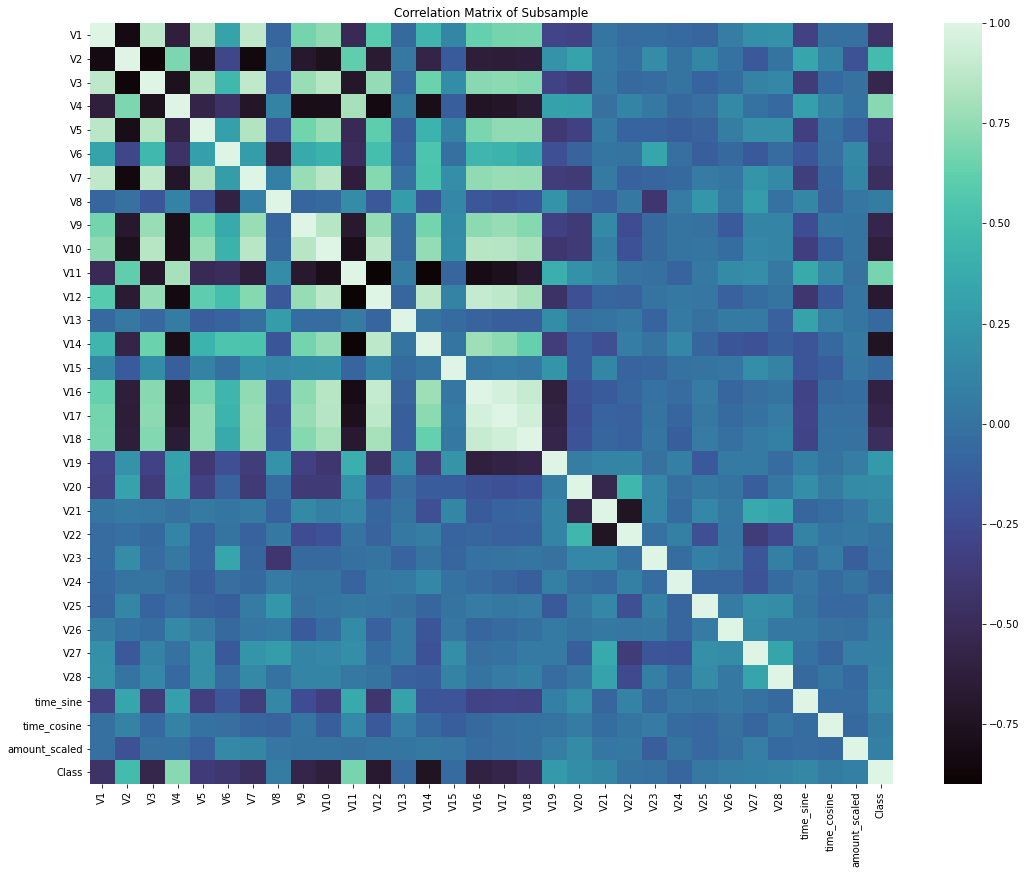

In [17]:
# Correlation matrix of subsampled df
fig, ax = plt.subplots(figsize = (18,14))
sns.heatmap(subsampled_example.corr(), ax = ax, cmap = 'mako')
ax.set_title('Correlation Matrix of Subsample')

In [18]:
# Correlation coefficients of subsampled df
print(subsampled_example.corr().Class.sort_values())

V14             -0.751117
V12             -0.680934
V10             -0.625113
V16             -0.600179
V9              -0.560673
V17             -0.560079
V3              -0.556588
V18             -0.481894
V7              -0.472168
V1              -0.438882
V6              -0.397220
V5              -0.369255
V24             -0.084136
V13             -0.057906
V15             -0.053845
V23             -0.007162
V22             -0.000852
V25              0.039555
time_cosine      0.059361
V8               0.061730
V26              0.064958
amount_scaled    0.089034
V27              0.090676
V28              0.094904
V21              0.131376
time_sine        0.140792
V20              0.174069
V19              0.252452
V2               0.487615
V11              0.678715
V4               0.719905
Class            1.000000
Name: Class, dtype: float64


Within this subsample we observe that the columns have varying degrees of correlations, with V14, V12, and V10 being the most negatively correlated to 'Class', and V4, V11, and V2 being the most positively correlated.

Text(0.5, 1.0, 'Correlation Matrix of Subsample')

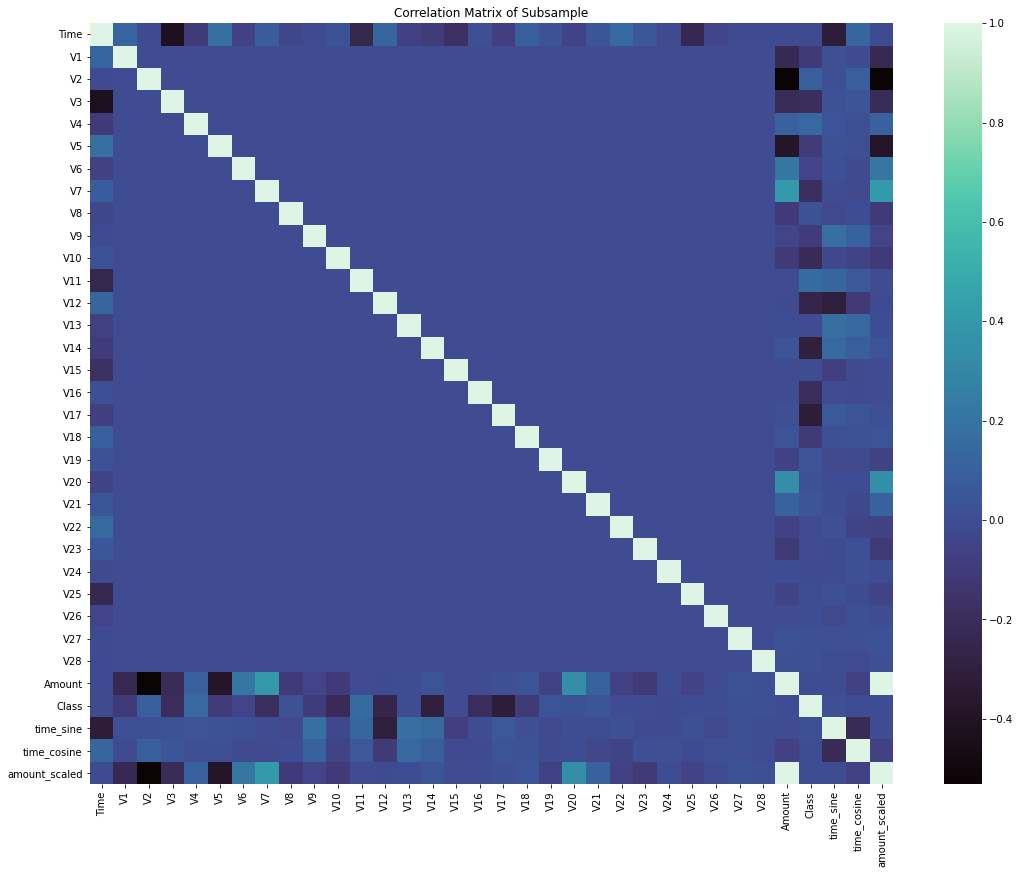

In [19]:
# Correlation matrix of full df
fig, ax = plt.subplots(figsize = (18,14))
sns.heatmap(df.corr(), ax = ax, cmap = 'mako')
ax.set_title('Correlation Matrix of Subsample')

In [20]:
# Correlation coefficients of full df
print(df.corr().Class.sort_values()) # see the correlations numerically

V17             -0.326481
V14             -0.302544
V12             -0.260593
V10             -0.216883
V16             -0.196539
V3              -0.192961
V7              -0.187257
V18             -0.111485
V1              -0.101347
V9              -0.097733
V5              -0.094974
V6              -0.043643
Time            -0.012323
V24             -0.007221
V13             -0.004570
V15             -0.004223
V23             -0.002685
V22              0.000805
V25              0.003308
V26              0.004455
amount_scaled    0.005632
Amount           0.005632
time_cosine      0.005950
V28              0.009536
time_sine        0.012808
V27              0.017580
V8               0.019875
V20              0.020090
V19              0.034783
V21              0.040413
V2               0.091289
V4               0.133447
V11              0.154876
Class            1.000000
Name: Class, dtype: float64


When looking at the correlation matrix and coefficients of the original dataset, the rankings of the 'V' columns with regards to correlations to fraud remains similar to the undersampled data, but the magnitude of the coefficients are significantly smaller suggesting that it may be harder to detect fraud using a model trained on the original data.

Text(0.5, 1.0, 'V10')

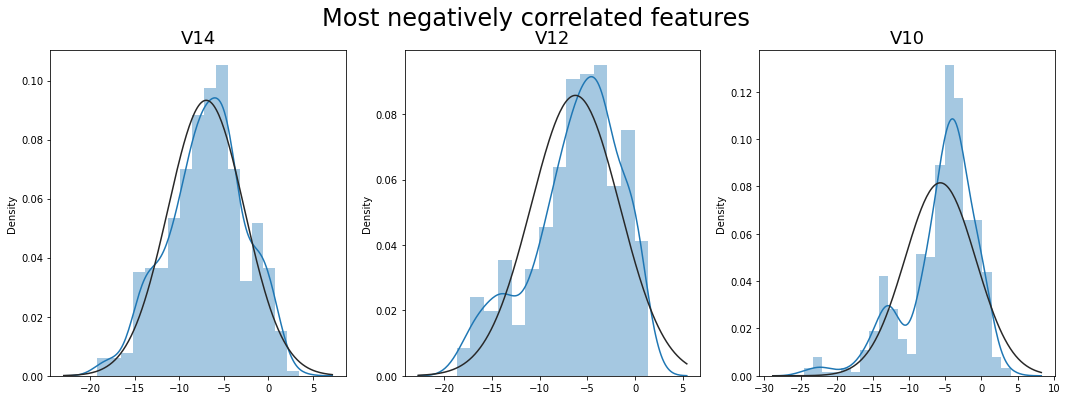

In [21]:
# Distribution before removing outliers
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Most negatively correlated features', fontsize = 24)
sns.distplot(subsampled_example['V14'].loc[subsampled_example['Class'] == 1].values, ax = ax1, fit = stats.norm)
ax1.set_title('V14', fontsize = 18)
sns.distplot(subsampled_example['V12'].loc[subsampled_example['Class'] == 1].values, ax = ax2, fit = stats.norm)
ax2.set_title('V12', fontsize = 18)
sns.distplot(subsampled_example['V10'].loc[subsampled_example['Class'] == 1].values, ax = ax3, fit = stats.norm)
ax3.set_title('V10', fontsize = 18)

Text(0.5, 1.0, 'V2')

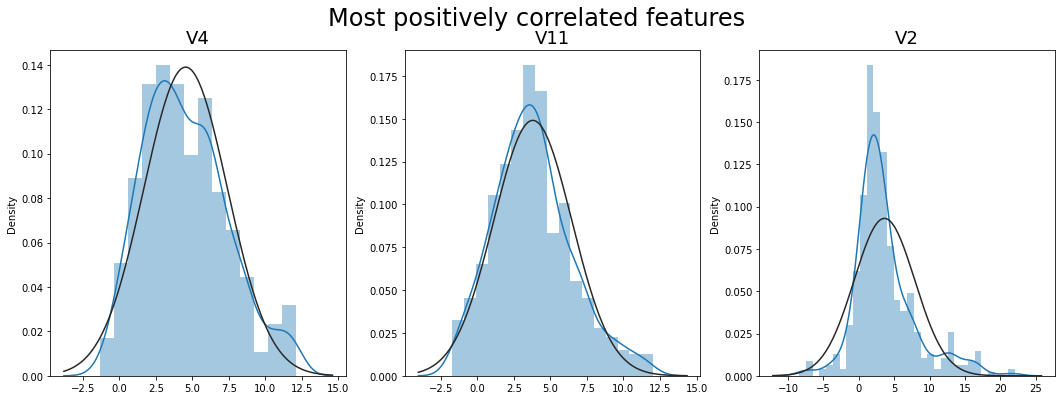

In [22]:
# Distribution before removing outliers
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Most positively correlated features', fontsize = 24)
sns.distplot(subsampled_example['V4'].loc[subsampled_example['Class'] == 1].values, ax = ax1, fit = stats.norm)
ax1.set_title('V4', fontsize = 18)
sns.distplot(subsampled_example['V11'].loc[subsampled_example['Class'] == 1].values, ax = ax2, fit = stats.norm)
ax2.set_title('V11', fontsize = 18)
sns.distplot(subsampled_example['V2'].loc[subsampled_example['Class'] == 1].values, ax = ax3, fit = stats.norm)
ax3.set_title('V2', fontsize = 18)

The above shows the most correlated features and their distributions, with the black line showing what a gaussian distribution would look like.

In [23]:
# Removing extreme outliers
def remove_extreme(df, feature, multiplier):
    feature_fraud = df[str(feature)].loc[df.Class == 1].values
    q25, q75 = np.percentile(feature_fraud,25), np.percentile(feature_fraud, 75)
    feature_cutoff = (q75-q25)*multiplier
    feature_lower, feature_upper = q25-feature_cutoff, q75+feature_cutoff
    
    outliers = [x for x in feature_fraud if x < feature_lower or x > feature_upper]
    print("{} outliers found for feature {}".format(len(outliers), feature))
    
    df = df.drop(df[(df[str(feature)] > feature_upper) | (df[str(feature)] < feature_lower)].index)
    return df

subsampled_no_outliers = subsampled_example.copy()
columns = list(subsampled_no_outliers.columns)[1:29]
columns = ['V14','V12','V10','V4','V11','V2']
for c in columns:
    subsampled_no_outliers = remove_extreme(subsampled_no_outliers, str(c), 1.5)

4 outliers found for feature V14
4 outliers found for feature V12
27 outliers found for feature V10
8 outliers found for feature V4
9 outliers found for feature V11
44 outliers found for feature V2


Text(0.5, 1.0, 'V10')

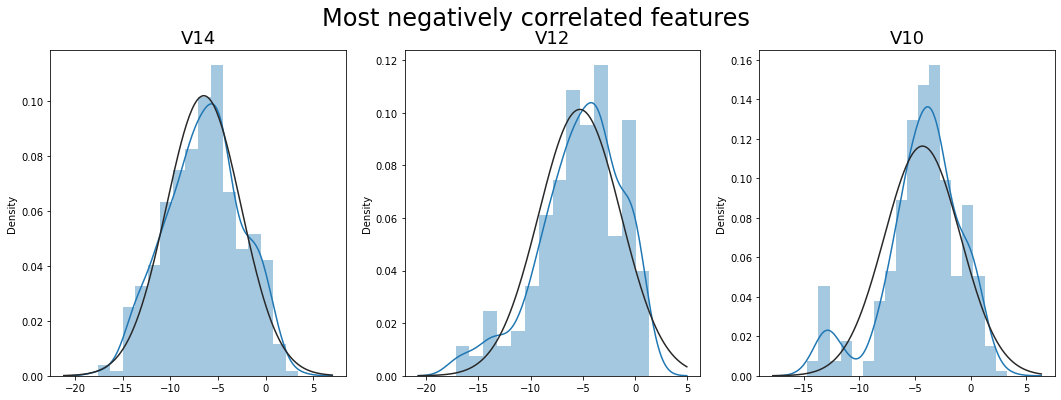

In [24]:
# Distribution after removing outliers from most correlated features
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Most negatively correlated features', fontsize = 24)
sns.distplot(subsampled_no_outliers['V14'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax1, fit = stats.norm)
ax1.set_title('V14', fontsize = 18)
sns.distplot(subsampled_no_outliers['V12'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax2, fit = stats.norm)
ax2.set_title('V12', fontsize = 18)
sns.distplot(subsampled_no_outliers['V10'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax3, fit = stats.norm)
ax3.set_title('V10', fontsize = 18)

Text(0.5, 1.0, 'V2')

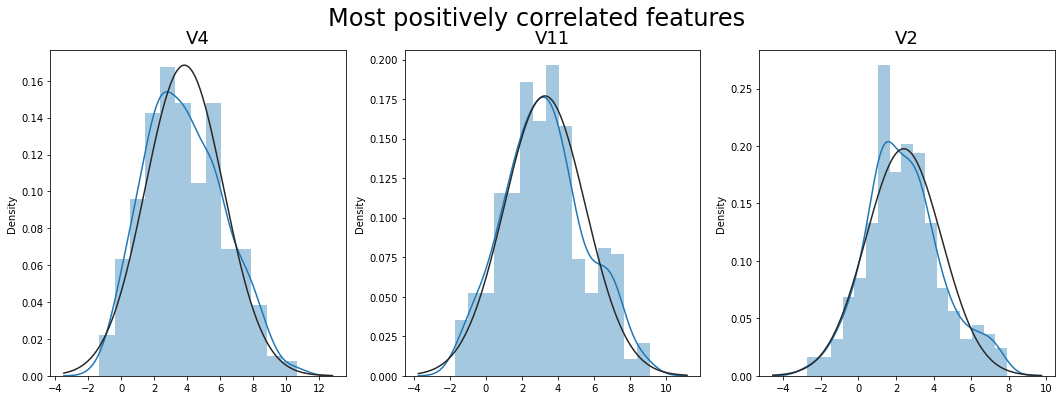

In [25]:
# Distribution after removing outliers from most correlated features
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Most positively correlated features', fontsize = 24)
sns.distplot(subsampled_no_outliers['V4'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax1, fit = stats.norm)
ax1.set_title('V4', fontsize = 18)
sns.distplot(subsampled_no_outliers['V11'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax2, fit = stats.norm)
ax2.set_title('V11', fontsize = 18)
sns.distplot(subsampled_no_outliers['V2'].loc[subsampled_no_outliers['Class'] == 1].values, ax = ax3, fit = stats.norm)
ax3.set_title('V2', fontsize = 18)

By removing the extreme outliers, we bring the distribution of the features closer to Gaussian and potentially improving how well the model will generalise.

Text(0.5, 1.0, 'T-SNE')

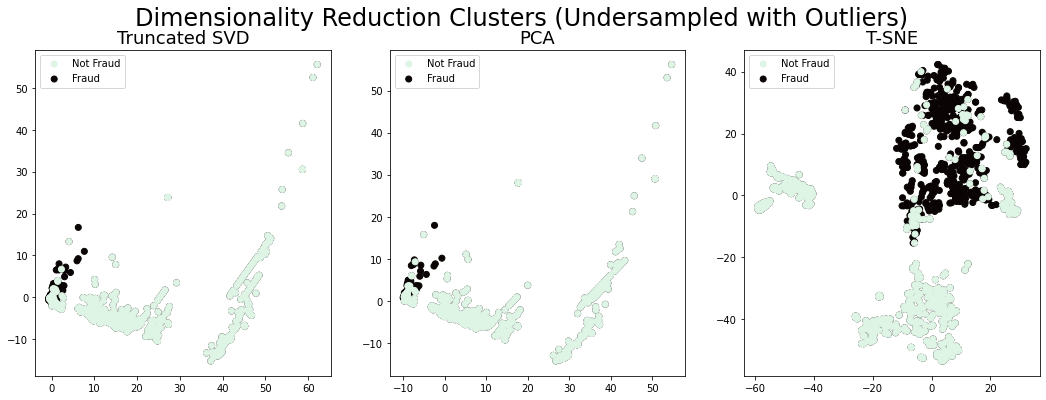

In [26]:
# Dimensionality reduction

# With outliers
X = subsampled_example.drop('Class', axis = 1)
y = subsampled_example['Class']

X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 33).fit_transform(X.values)
X_pca = PCA(n_components = 2, random_state = 33).fit_transform(X.values)
X_tsne = TSNE(n_components = 2, random_state = 33).fit_transform(X.values)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Dimensionality Reduction Clusters (Undersampled with Outliers)', fontsize = 24)
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax1.legend()
ax1.set_title('Truncated SVD', fontsize = 18)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax2.legend()
ax2.set_title('PCA', fontsize = 18)
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax3.legend()
ax3.set_title('T-SNE', fontsize = 18)

Text(0.5, 1.0, 'T-SNE')

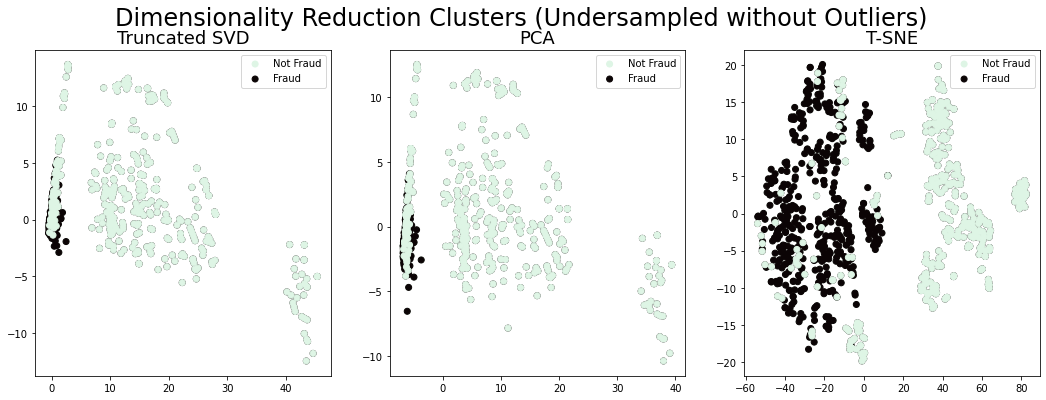

In [27]:
# Without outliers
X = subsampled_no_outliers.drop('Class', axis = 1)
y = subsampled_no_outliers['Class']

X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 33).fit_transform(X.values)
X_pca = PCA(n_components = 2, random_state = 33).fit_transform(X.values)
X_tsne = TSNE(n_components = 2, random_state = 33).fit_transform(X.values)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Dimensionality Reduction Clusters (Undersampled without Outliers)', fontsize = 24)
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax1.legend()
ax1.set_title('Truncated SVD', fontsize = 18)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax2.legend()
ax2.set_title('PCA', fontsize = 18)
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y == 0), cmap ='mako', label = 'Not Fraud')
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y == 1), cmap ='mako', label = 'Fraud')
ax3.legend()
ax3.set_title('T-SNE', fontsize = 18)

Looking at the clusters visually, it appears that clustering with and without the outliers both do not lead to clearly separable clusters. In this instance we have an additional T-SNE plot that appears to differentiate the clusters more clearly than truncated SVD or PCA reduction. T-SNE is not used for the original and oversampled dataset due to long computational times.


<a id = '3.2'></a>
### 3.2 Oversampling
Another method to deal with class imbalance is by oversampling the minority class to match the number of majority class using SMOTE.

In [28]:
# SMOTE Oversampling
X = df.drop(['Class','Time','Amount'], axis = 1)
y = df['Class']
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X, y)

counter = Counter(y_over)
print(counter)

smote_example = pd.concat([X_over,y_over], axis = 1)

X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 33).fit_transform(X_over.values)
X_pca = PCA(n_components = 2, random_state = 33).fit_transform(X_over.values)

Counter({0: 284315, 1: 284315})


Text(0.5, 1.0, 'Correlation Matrix of Subsample')

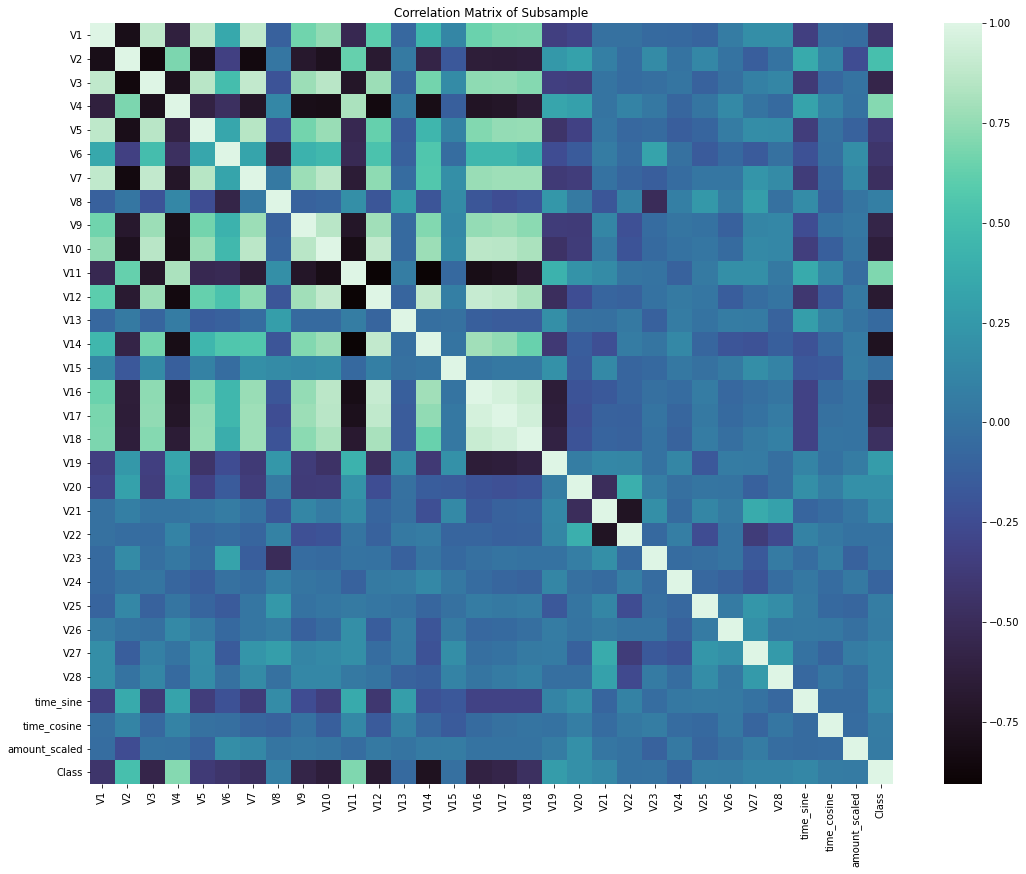

In [29]:
# Correlation matrix for oversampled data
fig, ax = plt.subplots(figsize = (18,14))
sns.heatmap(smote_example.corr(), ax = ax, cmap = 'mako')
ax.set_title('Correlation Matrix of Subsample')

In [30]:
# Correlation coefficients
print(smote_example.corr().Class.sort_values()) # see the correlations numerically

V14             -0.759110
V12             -0.682452
V10             -0.637343
V16             -0.597685
V9              -0.574628
V17             -0.564520
V3              -0.564190
V7              -0.478851
V18             -0.471199
V1              -0.426058
V6              -0.423744
V5              -0.383656
V24             -0.100706
V13             -0.063503
V15             -0.025989
V22             -0.006173
V23             -0.002138
amount_scaled    0.049014
time_cosine      0.056578
V26              0.058325
V25              0.067330
V8               0.079782
V27              0.100454
V28              0.104333
time_sine        0.129550
V21              0.142288
V20              0.189390
V19              0.276741
V2               0.502606
V11              0.696976
V4               0.711676
Class            1.000000
Name: Class, dtype: float64


Similary, we find the same few features being the features most correlated to fraud.

Text(0.5, 1.0, 'PCA')

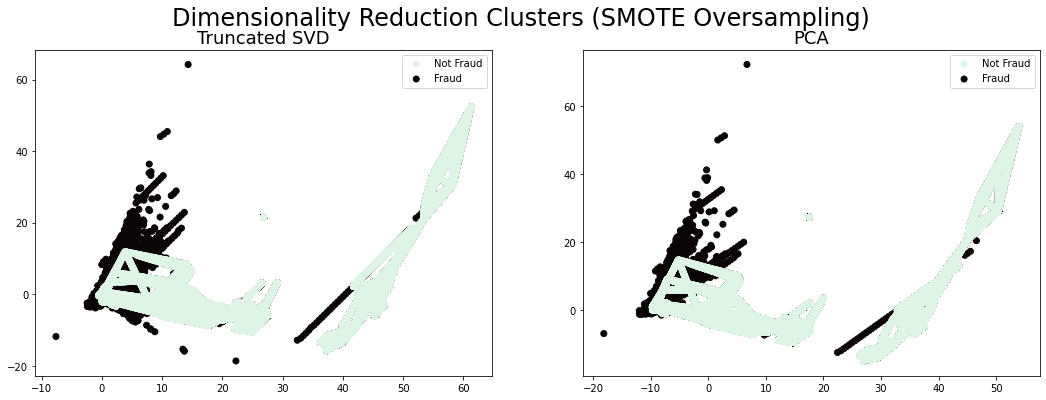

In [31]:
# Clustering oversampling
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (18,6))
fig.suptitle('Dimensionality Reduction Clusters (SMOTE Oversampling)', fontsize = 24)
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y_over == 0), cmap ='mako', label = 'Not Fraud')
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y_over == 1), cmap ='mako', label = 'Fraud')
ax1.legend()
ax1.set_title('Truncated SVD', fontsize = 18)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y_over == 0), cmap ='mako', label = 'Not Fraud')
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y_over == 1), cmap ='mako', label = 'Fraud')
ax2.legend()
ax2.set_title('PCA', fontsize = 18)

Again, the clusters appear to not be clearly separable.


<a id = '3.3'></a>
### 3.3 Over and Undersampling
Lastly, we could combine both over and under sampling by using both the RandomUnderSampler and SMOTE to reduce the class imbalance. In this case we will oversample the minority class to 10% of the majority class, before undersampling the majority class to achieve a 1:2 ratio of fraud:non-fraud cases.

In [32]:
# SMOTE Oversampling and Random Undersampling
X = df.drop(['Class','Time','Amount'], axis = 1)
y = df['Class']
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)

steps = [('o', over),('u', under)]
pipeline = imbPipeline(steps = steps)
X_ou, y_ou = pipeline.fit_resample(X, y)

counter = Counter(y_ou)

overunder_example = pd.concat([X_over,y_over], axis = 1)

X_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized', random_state = 33).fit_transform(X_ou.values)
X_pca = PCA(n_components = 2, random_state = 33).fit_transform(X_ou.values)
X_tsne = TSNE(n_components = 2, random_state = 33).fit_transform(X_ou.values)

Text(0.5, 1.0, 'Correlation Matrix of Subsample')

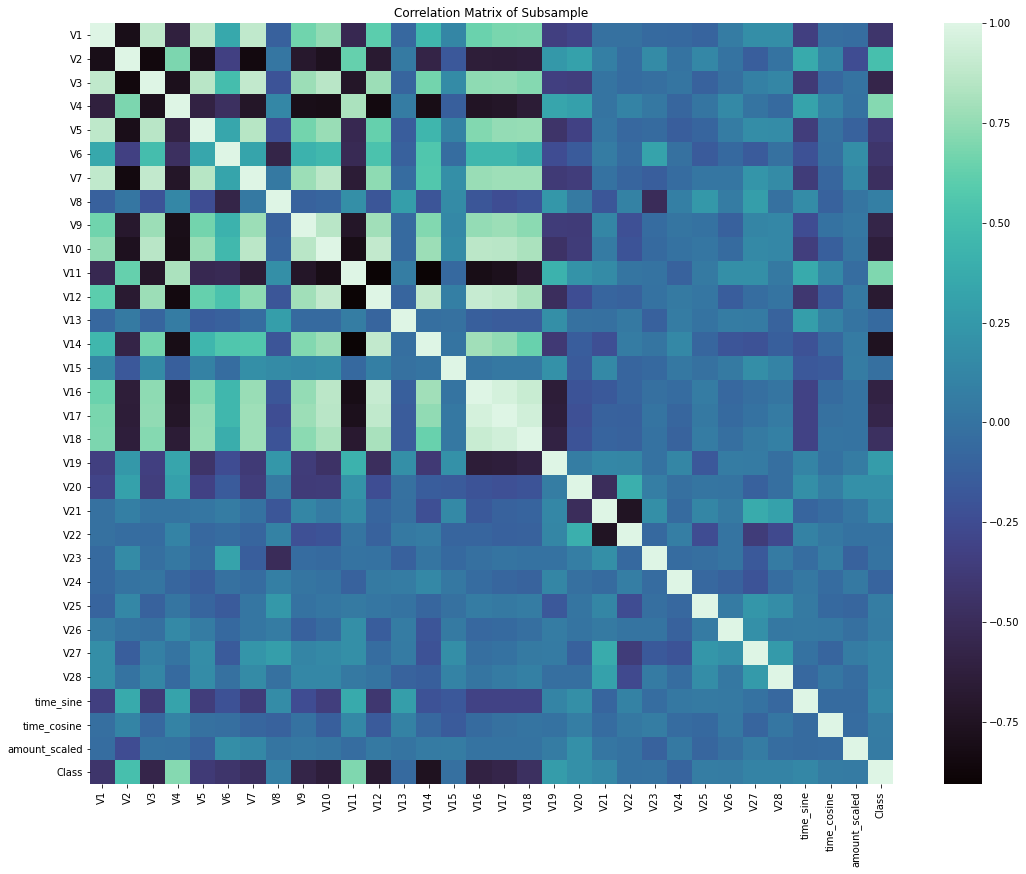

In [33]:
# Correlation matrix for oversampled data
fig, ax = plt.subplots(figsize = (18,14))
sns.heatmap(overunder_example.corr(), ax = ax, cmap = 'mako')
ax.set_title('Correlation Matrix of Subsample')

In [34]:
# Correlation coefficients
print(overunder_example.corr().Class.sort_values()) # see the correlations numerically

V14             -0.759110
V12             -0.682452
V10             -0.637343
V16             -0.597685
V9              -0.574628
V17             -0.564520
V3              -0.564190
V7              -0.478851
V18             -0.471199
V1              -0.426058
V6              -0.423744
V5              -0.383656
V24             -0.100706
V13             -0.063503
V15             -0.025989
V22             -0.006173
V23             -0.002138
amount_scaled    0.049014
time_cosine      0.056578
V26              0.058325
V25              0.067330
V8               0.079782
V27              0.100454
V28              0.104333
time_sine        0.129550
V21              0.142288
V20              0.189390
V19              0.276741
V2               0.502606
V11              0.696976
V4               0.711676
Class            1.000000
Name: Class, dtype: float64


Same as before, the same features appear as the features most correlated to fraud.

Text(0.5, 1.0, 'T-SNE')

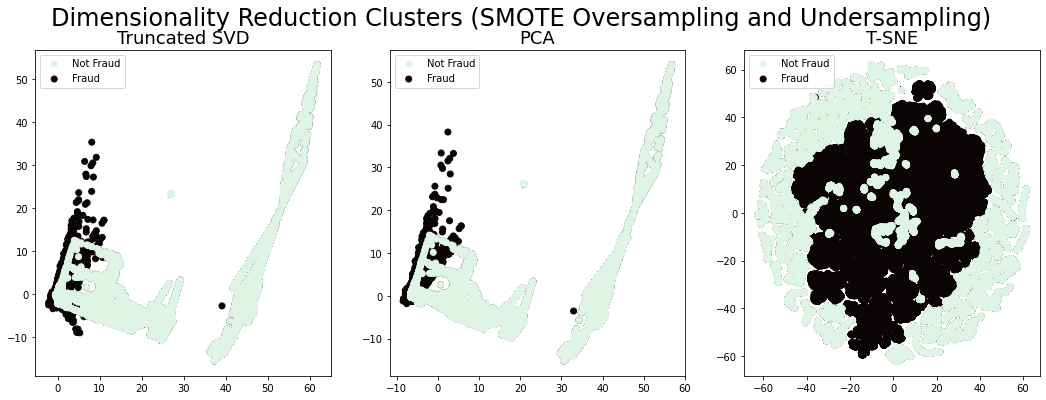

In [35]:
# Clustering Over and undersampled data
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (18,6))
fig.suptitle('Dimensionality Reduction Clusters (SMOTE Oversampling and Undersampling)', fontsize = 24)
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y_ou == 0), cmap ='mako', label = 'Not Fraud')
ax1.scatter(X_svd[:,0], X_svd[:,1], c = (y_ou == 1), cmap ='mako', label = 'Fraud')
ax1.legend()
ax1.set_title('Truncated SVD', fontsize = 18)
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y_ou == 0), cmap ='mako', label = 'Not Fraud')
ax2.scatter(X_pca[:,0], X_pca[:,1], c = (y_ou == 1), cmap ='mako', label = 'Fraud')
ax2.legend()
ax2.set_title('PCA', fontsize = 18)
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y_ou == 0), cmap ='mako', label = 'Not Fraud')
ax3.scatter(X_tsne[:,0], X_tsne[:,1], c = (y_ou == 1), cmap ='mako', label = 'Fraud')
ax3.legend()
ax3.set_title('T-SNE', fontsize = 18)

The truncated SVD and PCA reducation clusters looks similar to the ones found using the oversampled dataset, while the T-SNE 
appears to be able to better separate data points from the two clusters.

***

<a id = '4'></a>
## 4. Binary Classification
In this section we will be comparing models trained under different conditions to detect fraud. 

In [73]:
# Initialisations

X = df.drop(['amount_scaled','Class','Time'], axis = 1)
y = df['Class']

# split to get (train+validation) and (test) sets
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33, stratify = y)

# Scoring metrics
scoring = {'acc': 'accuracy',
           'prec': 'precision',
           'rec': 'recall',
           'f1': 'f1',
           'roc': 'roc_auc'
           }

# Classifiers
classifiers = {'LogReg': LogisticRegression(),
               'NB': GaussianNB(),
               'KNC': KNeighborsClassifier(),
               'SVC': SVC(probability = True),
               'RFC': RandomForestClassifier(n_estimators = 25)}

# classifiers , knc/svc too slow
classifiers2 = {'LogReg': LogisticRegression(),
               'NB': GaussianNB(),
               'RFC': RandomForestClassifier(n_estimators = 25)}

# RobustScaler
scaler = RobustScaler()

A holdout set containing 20% of the original data will be left aside for evaluation of model performance. Cross validation will be conducted on the remaining 80%. Sampling and scaling methods will be applied/fitted to the training set after splitting the dataset to prevent data leakage.

In [53]:
# Function for scoring cross validation
def cv(X, y, classifier, name, smote, scaler, n, scores_df):
    accuracy = []
    recall = []
    precision = []
    f1 = []
    
    for i in range(n):
        print(str(name) + ' ' + str(i))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y)
        X_train['amount_scaled'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1,1))
        X_train = X_train.drop('Amount', axis = 1)
        
        if smote != None:
            X_train, y_train = smote.fit_resample(X_train, y_train)
        classifier.fit(X_train, y_train)
        
        X_test['amount_scaled'] = scaler.transform(X_test['Amount'].values.reshape(-1,1))
        X_test = X_test.drop('Amount', axis = 1)
        pred = classifier.predict(X_test)
        
        accuracy.append(accuracy_score(y_test, pred))
        precision.append(precision_score(y_test, pred))
        recall.append(recall_score(y_test, pred))
        f1.append(f1_score(y_test, pred))
    scores_df['accuracy '+ str(name)] = accuracy
    scores_df['precision '+ str(name)] = precision
    scores_df['recall '+ str(name)] = recall
    scores_df['f1 '+ str(name)] = f1
    return scores_df

# Function to predict on holdout test data
def evaluate(X_val, y_val, X_test, y_test, classifier, smote, scaler):
    X_val['amount_scaled'] = scaler.fit_transform(X_val['Amount'].values.reshape(-1,1))
    X_val = X_val.drop('Amount', axis = 1)
    
    if smote != None:
        X_val, y_val = smote.fit_resample(X_val, y_val)
    classifier.fit(X_val, y_val)
    
    X_test['amount_scaled'] = scaler.fit_transform(X_test['Amount'].values.reshape(-1,1))
    X_test = X_test.drop('Amount', axis = 1)
    
    pred = classifier.predict(X_test)
    pred_proba = classifier.predict_proba(X_test)
    print(confusion_matrix(y_test,pred))
    return pred_proba

<a id = '4.1'></a>
### 4.1 Baseline
First the baseline model will be built using the dataset with no sampling methods applied.

In [54]:
scores_baseline = pd.DataFrame()

for key, classifier in classifiers2.items():
    scores_baseline = cv(X_val, y_val, classifier, key, None, scaler, 5, scores_baseline)

LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [55]:
print(scores_baseline.mean()[::4])
print(scores_baseline.mean()[1::4])
print(scores_baseline.mean()[2::4])
print(scores_baseline.mean()[3::4])

accuracy LogReg    0.999127
accuracy NB        0.977902
accuracy RFC       0.999574
dtype: float64
precision LogReg    0.873612
precision NB        0.062283
precision RFC       0.935727
dtype: float64
recall LogReg    0.579747
recall NB        0.835443
recall RFC       0.810127
dtype: float64
f1 LogReg    0.692746
f1 NB        0.115920
f1 RFC       0.868029
dtype: float64


When scoring an imbalanced classification problem, we see that accuracy is a very poor evaluation metric to use. All three models achieved an accuracy of over 97% from the above, but if we look at the results more closely we will realise that the Naive Bayes (NB) model actually has a precision of 6%. What this means is that for every 1 fraud case that is correctly classified by the model, approximately 15 other non-fraud cases as misclassified as fraud as well.

In this case what should be used are the precision and recall metrics, or the f1 score which is a scoring metric that places the same importance to both precision and recall.

Original,LogReg
[[56856     8]
 [   36    62]]
AUC : 0.7565453196223338
Original,NB
[[55656  1208]
 [   18    80]]
AUC : 0.41409469574547036
Original,RFC
[[56861     3]
 [   23    75]]
AUC : 0.8392673241987468


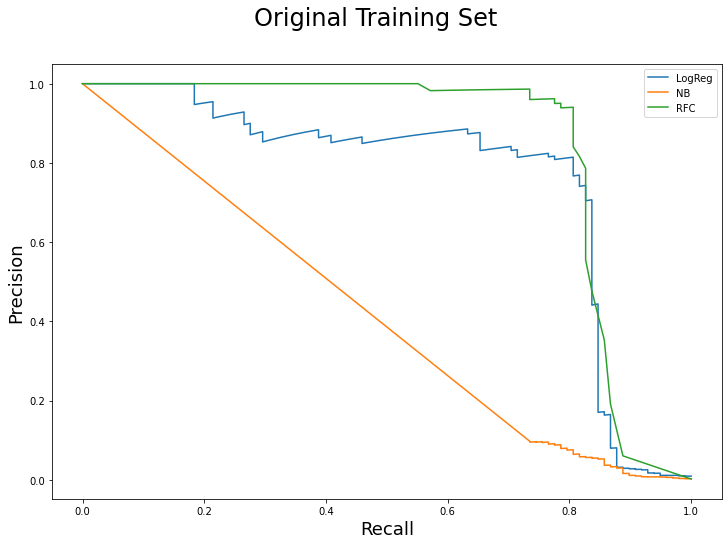

In [60]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Original Training Set', fontsize = 24)
for key,classifier in classifiers2.items()  :
    print('Original,' + str(key))
    proba = evaluate(X_val, y_val, X_test, y_test, classifier, None, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

Alternatively, the precision-recall curve is also a good way to visualize the model performance with larger area under curve (AUC) typically meaning better performance. Among the three models tested random forest classifier appears to be the best performer with logistic regression close behind.

<a id = '4.2'></a>
### 4.2 Undersampling
In this section the majority class will be undersampled to the same number of samples as the minority class.

In [38]:
# SMOTE pipeline
undersample = RandomUnderSampler(sampling_strategy = 1)
under_ = imbPipeline(steps = [('undersample', undersample)])

# Dataframe to store cross validation scores
scores_under = pd.DataFrame()

# Modelling using Undersampled data
for key, classifier in classifiers.items():
    scores_under = cv(X_val, y_val, classifier, key, under_, scaler, 5, scores_under)

LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
KNC 0
KNC 1
KNC 2
KNC 3
KNC 4
SVC 0
SVC 1
SVC 2
SVC 3
SVC 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [67]:
print(scores_under.mean()[3::4])

f1 LogReg    0.079585
f1 NB        0.079052
f1 KNC       0.109320
f1 SVC       0.152511
f1 RFC       0.090991
dtype: float64


Undersampled,LogReg
[[55057  1807]
 [   11    87]]
AUC : 0.40367256993547085
Undersampled,NB
[[55051  1813]
 [   15    83]]
AUC : 0.4269131209310503
Undersampled,KNC
[[55459  1405]
 [   13    85]]
AUC : 0.6002533908764354
Undersampled,SVC
[[55816  1048]
 [   13    85]]
AUC : 0.6932852823199779
Undersampled,RFC
[[55003  1861]
 [   10    88]]
AUC : 0.7468231899868731


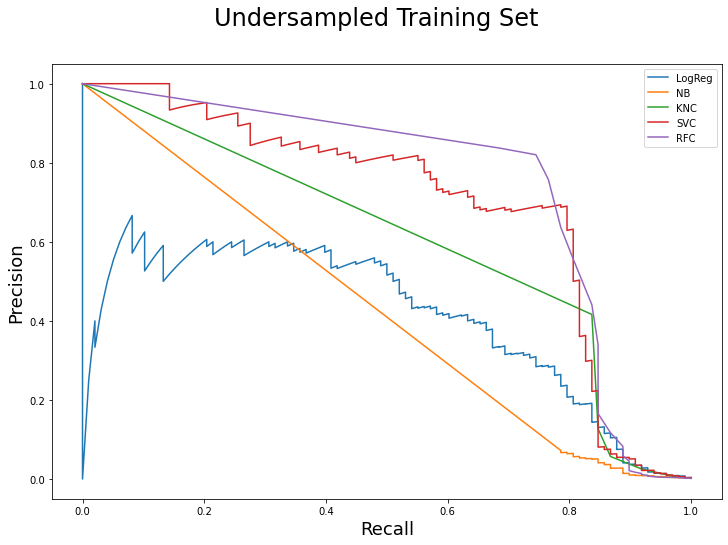

In [61]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Undersampled Training Set', fontsize = 24)
for key,classifier in classifiers.items()  :
    print('Undersampled,' + str(key))
    proba = evaluate(X_val, y_val, X_test, y_test, classifier, under_, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

Compared to the baseline, the undersampled models have significantly poorer performance. This can be attributed to the removal of a significant portion of the original dataset along with any information they may provide.

<a id = '4.3'></a>
### 4.3 Oversampling
In this section minority class will be oversampled to have equal number of samples to majority class.

In [41]:
# SMOTE pipeline
oversample = SMOTE()
over_ = imbPipeline(steps = [('oversample', oversample)])

# Dataframe to store cross validation scores
scores_over = pd.DataFrame()

# Modelling using Oversampled data
for key, classifier in classifiers2.items():
    scores_over = cv(X_val, y_val, classifier, key, over_, scaler, 5, scores_over)  

LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [68]:
print(scores_over.mean()[3::4])

f1 LogReg    0.085363
f1 NB        0.082968
f1 RFC       0.834458
dtype: float64


Oversampled,LogReg
[[55559  1305]
 [   11    87]]
AUC : 0.7325474470444286
Oversampled,NB
[[55481  1383]
 [   16    82]]
AUC : 0.42786168237557287
Oversampled,RFC
[[56857     7]
 [   21    77]]
AUC : 0.8339250268571085


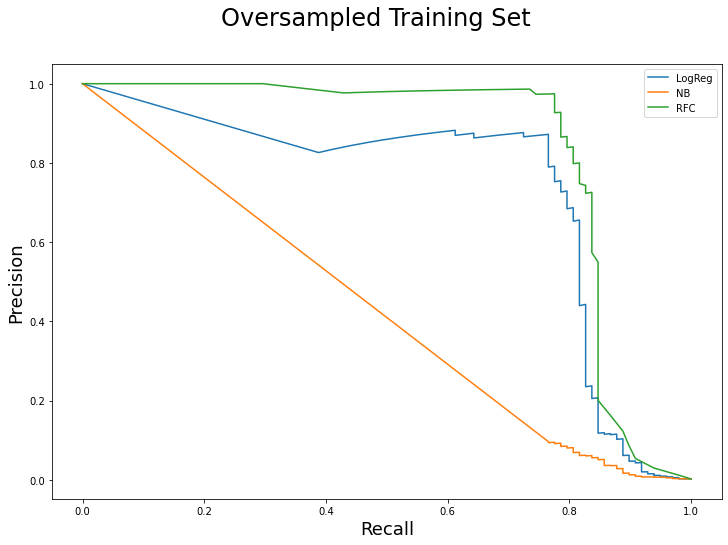

In [62]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Oversampled Training Set', fontsize = 24)
for key,classifier in classifiers2.items()  :
    print('Oversampled,' + str(key))
    proba = evaluate(X_val, y_val, X_test, y_test, classifier, over_, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

When comparing to the baseline models, the oversampled models have similar performance. However, the number of training samples in the oversampled models are approximately double of baseline, which results in higher computational costs.

<a id = '4.4'></a>
### 4.4 Over and Undersampling
In this section the dataset will be over and undersampled to a 1:2 ratio for fraud:non-fraud cases.

In [44]:
# SMOTE pipeline
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
overunder = imbPipeline(steps = [('over', over), ('under', under)])

# Dataframe to store cross validation scores
scores_overunder = pd.DataFrame()

# Over and Undersampled
for key, classifier in classifiers2.items():
    scores_overunder = cv(X_val, y_val, classifier, key, overunder, scaler, 5, scores_overunder)

LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [69]:
print(scores_overunder.mean()[3::4])

f1 LogReg    0.149789
f1 NB        0.083951
f1 RFC       0.767101
dtype: float64


Oversampled,LogReg
[[56219   645]
 [   11    87]]
AUC : 0.7257959997807136
Oversampled,NB
[[55512  1352]
 [   16    82]]
AUC : 0.4280972590784736
Oversampled,RFC
[[56842    22]
 [   19    79]]
AUC : 0.8295117972373017


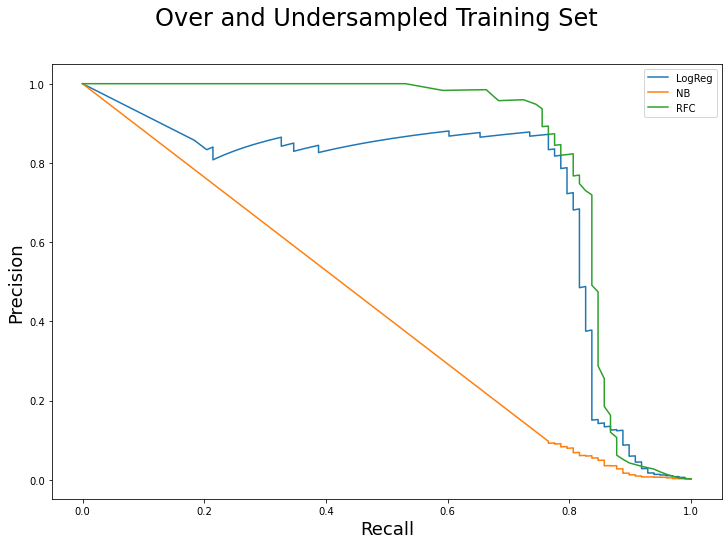

In [63]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Over and Undersampled Training Set', fontsize = 24)
for key,classifier in classifiers2.items()  :
    print('Oversampled,' + str(key))
    proba = evaluate(X_val, y_val, X_test, y_test, classifier, overunder, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

In comparison to baseline, the performance of these models are very slightly worse. For this particular dataset, we observe that the different sampling methods do not result in increases in model performances. However, we were able to explore and observe how the different sampling methods will affect the models trained.

Undersampling removes a large portion of the dataset which may lead to a decrease in model performance, although this also leads to significantly lower computational time.

Oversampling adds a large number of new data points to the dataset which may lead to an increase in model performance, but computational time will consequently become longer. The oversampled data points also depends on the quality of the data points of the minority class available in the first place.

Over and undersampling when used together can reduce the class imbalance problem, leading to a better performance than undersampling and even oversampling in certain cases, with computational time being in between the two.

***

<a id = '4.5'></a>
## 4.5 Outliers
We shall explore the effects of removing extreme outliers from the dataset.

### Oversampling

In [74]:
# SMOTE pipeline
over_ = imbPipeline(steps = [('oversample', oversample)])

# Remove extreme outliers from training set
columns = ['V14','V12','V10','V4','V11','V2']
X_val2 = X_val.copy()
X_val2['Class'] = y_val
for c in columns:
    X_val2 = remove_extreme(X_val2, str(c), 1.5)
y_val2 = X_val2.Class
X_val2 = X_val2.drop('Class', axis = 1)
    
# Dataframe to store cross validation scores
scores_over2 = pd.DataFrame()

# Modelling using Oversampled data
for key, classifier in classifiers2.items():
    scores_over2 = cv(X_val2, y_val2, classifier, key, over_, scaler, 5, scores_over2)      

4 outliers found for feature V14
4 outliers found for feature V12
23 outliers found for feature V10
5 outliers found for feature V4
7 outliers found for feature V11
35 outliers found for feature V2
LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [75]:
print(scores_over2.mean()[3::4])

f1 LogReg    0.081050
f1 NB        0.085171
f1 RFC       0.844954
dtype: float64


Oversampled,LogReg
[[55152  1712]
 [   11    87]]
AUC : 0.6386660529762509
Oversampled,NB
[[54216  2648]
 [   13    85]]
AUC : 0.4261958329221485
Oversampled,RFC
[[56857     7]
 [   28    70]]
AUC : 0.8121182763171233


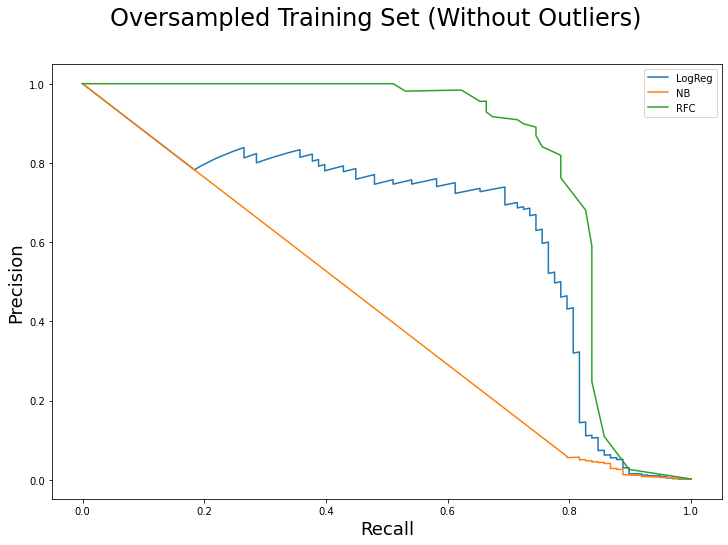

In [80]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Oversampled Training Set (Without Outliers)', fontsize = 24)
for key,classifier in classifiers2.items()  :
    print('Oversampled,' + str(key))
    proba = evaluate(X_val2, y_val2, X_test, y_test, classifier, over_, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

When compared to the oversampled models containing outliers, removing outliers resulted in a slight decrease in performance.

### Over and undersampling

In [76]:
# SMOTE pipeline
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
overunder = imbPipeline(steps = [('over', over), ('under', under)])

# Dataframe to store cross validation scores
scores_overunder2 = pd.DataFrame()

# Remove extreme outliers from training set
columns = ['V14','V12','V10','V4','V11','V2']
X_val2 = X_val.copy()
X_val2['Class'] = y_val
for c in columns:
    X_val2 = remove_extreme(X_val2, str(c), 1.5)
y_val2 = X_val2.Class
X_val2 = X_val2.drop('Class', axis = 1)
    
    
# Over and Undersampled
for key, classifier in classifiers2.items():
    scores_overunder2 = cv(X_val2, y_val2, classifier, key, overunder, scaler, 5, scores_overunder2)

4 outliers found for feature V14
4 outliers found for feature V12
23 outliers found for feature V10
5 outliers found for feature V4
7 outliers found for feature V11
35 outliers found for feature V2
LogReg 0
LogReg 1
LogReg 2
LogReg 3
LogReg 4
NB 0
NB 1
NB 2
NB 3
NB 4
RFC 0
RFC 1
RFC 2
RFC 3
RFC 4


In [77]:
print(scores_overunder2.mean()[3::4])

f1 LogReg    0.143273
f1 NB        0.084810
f1 RFC       0.792966
dtype: float64


Oversampled,LogReg
[[55902   962]
 [   15    83]]
AUC : 0.5816799688625814
Oversampled,NB
[[54310  2554]
 [   13    85]]
AUC : 0.4268145176115912
Oversampled,RFC
[[56841    23]
 [   21    77]]
AUC : 0.7912000126415657


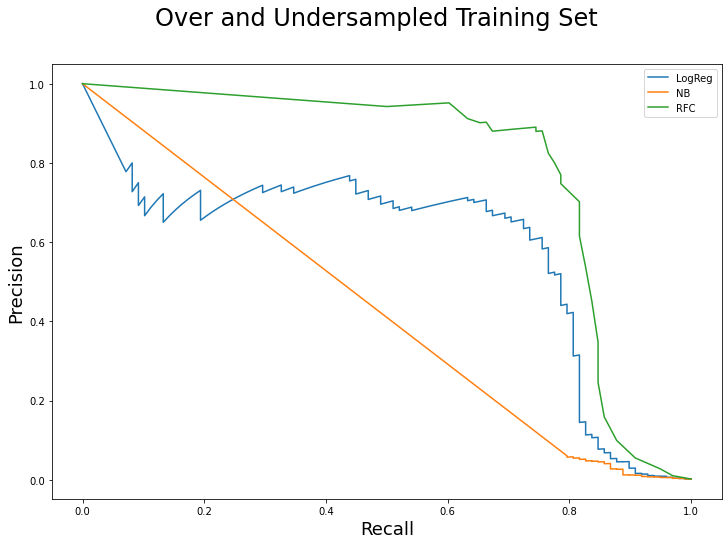

In [79]:
# Evaluate classifiers and plot precision-recall curve
fig, ax = plt.subplots(figsize = (12,8))
fig.suptitle('Over and Undersampled Training Set (Without Outliers)', fontsize = 24)
for key,classifier in classifiers2.items()  :
    print('Oversampled,' + str(key))
    proba = evaluate(X_val2, y_val2, X_test, y_test, classifier, overunder, scaler)
    proba_p, proba_r, _ = precision_recall_curve(y_test, proba[:,1])
    print('AUC :' , auc(proba_r, proba_p))
    ax.plot(proba_r, proba_p, label = str(key))
ax.set_xlabel('Recall', fontsize = 18)
ax.set_ylabel('Precision', fontsize = 18)
ax.legend()

Similarly, removing outliers for over and undersampled models results in a slight decrease in performance.

***

<a id = '5'></a>
## 5. Conclusion
In this notebook we have explored a credit card fraud detection dataset and built classification models based on different methods. For this particular dataset, we found that the sampling methods and removal of extreme outlier values do not provide any significant improvements to the baseline model performances. It was also noted that the dataset used only spans across a period of 48 hours. If a similar dataset that spans across a longer time frame is available, analysis of the dataset will be able to confirm if fraud cases are time correlated and in turn result in better analysis/modelling performance.